# In this portion we will explore feature elimination as well as feature selection in evaluating some classifiers' performances. Afterwards, we will statistically compare how well each set of features selected performs for these classifiers, and make a decision from these tests regarding further analyses. 

(447, 265)


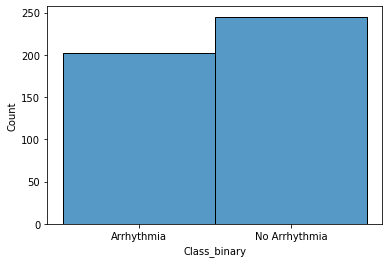

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.impute import SimpleImputer

np.random.seed(34)

arrhythmia_df = pd.read_csv('1_data_exploration_arrhythmia.csv')
print(arrhythmia_df.shape)
# let's level the playing field by collapsing classes 2-16 into one label - Arrhythmia
sns.histplot(arrhythmia_df['Class_binary'])

features_df = arrhythmia_df.drop(columns=['Class', 'Class_binary', 'Sex_categorical'], inplace=False)
X = SimpleImputer(strategy='most_frequent').fit_transform(features_df)
y = label_binarize(arrhythmia_df['Class_binary'], classes=['No Arrhythmia', 'Arrhythmia']).ravel()

features_imputed_df = pd.DataFrame(data=X, columns=features_df.columns)
labels_df = pd.DataFrame(data=y, columns=['Class_binary'])

arrhythmia = pd.concat([features_imputed_df, labels_df], axis=1)

By converting the many classes encoding Arrhythmia to a single label, we can nearly match the representation of the No Arrhythmia class.

There are plenty of features to use in this dataset - I want to select the most important features in aiding two classifiers to correctly diagnosing Arrhythmia. Below, recursive feature elimination is used to select rank 1-2 importances for both classifiers. Both sets of features are then intersected and joined (union) to compare.

In [2]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, recall_score
from sklearn.preprocessing import StandardScaler

# since Arrhythmia is a serious condition, I want to evaluate classification by the recall score
recall_scorer = make_scorer(recall_score, average='weighted')

best_feature_indices = []
for clf in [LogisticRegression(), LinearSVC()]:
    
    selector = RFECV(estimator=clf, cv=5, step=1, scoring=recall_scorer)
    scaler = StandardScaler()
    selector.fit(scaler.fit_transform(X), y)
    
    clf_selector_ranking = selector.ranking_
    rank1_feature_indices = np.where(selector.ranking_ <= 2)[0]
    
    best_feature_indices.append(rank1_feature_indices)

features_indices_intersection = np.intersect1d(best_feature_indices[0], best_feature_indices[1])
features_indices_union = np.union1d(best_feature_indices[0], best_feature_indices[1])

Text(0.5, 1.0, 'Union of RFE features')

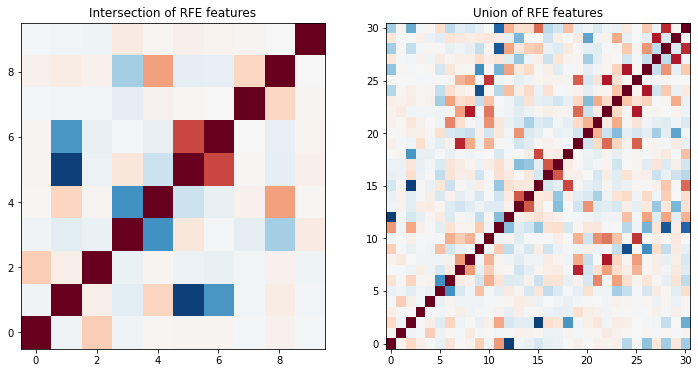

In [3]:
feature_names = np.array(features_df.columns)
features_union = feature_names[features_indices_union]
features_intersection = feature_names[features_indices_intersection]

fig, (ax_intersection, ax_union) = plt.subplots(1, 2, figsize=(12, 6))
ax_intersection.imshow(np.cov(StandardScaler().fit_transform(arrhythmia[features_intersection]), rowvar=False), aspect='auto', vmin=-1, vmax=1, cmap='RdBu_r', origin='lower')
ax_union.imshow(np.cov(StandardScaler().fit_transform(arrhythmia[features_union]), rowvar=False), aspect='auto', vmin=-1, vmax=1, cmap='RdBu_r', origin='lower')
ax_intersection.set_title('Intersection of RFE features')
ax_union.set_title('Union of RFE features')

Upon viewing the features' covariance matrix from Part 1, I considered PCA. With feature elimination removing a chunk of the highly correlated features, we should first investigate classification performance and use PCA as an alternative in the case that we are unsatisfied...

In [4]:
from sklearn.model_selection import train_test_split

# let's begin setting the stage for classification
split_dict = {'test_size': 0.25, 'shuffle': True}

# let's also hyper-parameterize the classifier(s)
param_grid = {'clf__dual': [True, False], 'clf__tol': [1e-3, 1e-4, 1e-5], 'clf__C': [0.1, 1, 10],
                     'clf__class_weight': [None, 'balanced']}
gridsearch_params = {'param_grid': param_grid, 'scoring': recall_scorer,
                     'return_train_score': True}

I am interested in evaluating the classifiers' performance using features both agreed upon to be important (intersection) as well as all features collectively deemed important (union).

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

svc_pipe = Pipeline([('sc', StandardScaler()), ('clf', LinearSVC())])
lr_pipe = Pipeline([('sc', StandardScaler()), ('clf', LogisticRegression())])

pipeline_dict = {'svc': svc_pipe, 'lr': lr_pipe}
features_dict = {'RFE Union': features_union, 'RFE Intersection': features_intersection}

results_dict = {}
for classifier_variation, estimator in pipeline_dict.items():
    search = GridSearchCV(estimator=estimator, **gridsearch_params)
    for features_variation, features in features_dict.items():
        
        X_train, X_test, y_train, y_test = train_test_split(arrhythmia[features], y, **split_dict)
        search.fit(X_train, y_train)
        results_df = pd.DataFrame(search.cv_results_)
        results_df.sort_values(by=['rank_test_score'], inplace=True)
        model_scores = results_df.filter(regex=r'split\d*_test_score')
        
        clf_feat_dict = {'scores': model_scores.dropna(), 'best_est': search.best_estimator_}
        
        results_dict[f'{classifier_variation}_{features_variation}'] = clf_feat_dict

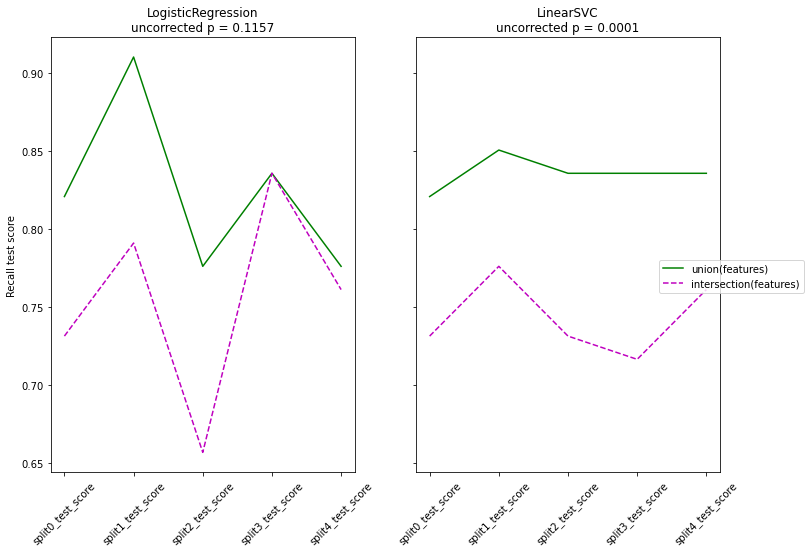

In [6]:
cols = results_dict['lr_RFE Union']['scores'].columns.tolist()
# let's compare the best scoring models
lr_union_scores = results_dict['lr_RFE Union']['scores'].iloc[0]
lr_intersect_scores = results_dict['lr_RFE Intersection']['scores'].iloc[0]

svc_union_scores = results_dict['svc_RFE Union']['scores'].iloc[0]
svc_intersect_scores = results_dict['svc_RFE Intersection']['scores'].iloc[0]

_, p_within_lr = ttest_ind(lr_union_scores, lr_intersect_scores)
_, p_within_svc = ttest_ind(svc_union_scores, svc_intersect_scores)

fig, (ax_lr, ax_svc) = plt.subplots(1, 2, figsize=(12,8), sharex=True, sharey=True)
ax_lr.plot(lr_union_scores.T, label='union(features)', c='g')
ax_lr.plot(lr_intersect_scores.T, ls='--', label='intersection(features)', c='m')
ax_svc.plot(svc_union_scores.T, c='g')
ax_svc.plot(svc_intersect_scores.T, ls='--', c='m')
for ax in [ax_lr, ax_svc]:
    ax.set_xticklabels(cols, rotation=45)

ax_lr.set_title(f'LogisticRegression\nuncorrected p = {p_within_lr.round(4)}')
ax_svc.set_title(f'LinearSVC\nuncorrected p = {p_within_svc.round(4)}')
labels, handles = ax_lr.get_legend_handles_labels()
ax_lr.set_ylabel('Recall test score')
fig.legend(labels, handles, 'center right')

Within-classifier comparisons, though un-corrected - and probably will not withstand correction - give me enough justification to remove using the intersection of agreed upon important features from subsequent analyses. That leaves us with comparing between classifiers using the union of important features.

In [7]:
del results_dict['lr_RFE Intersection']
del results_dict['svc_RFE Intersection']
results_dict['svc'] = results_dict.pop('svc_RFE Union')
results_dict['lr'] = results_dict.pop('lr_RFE Union')

In [8]:
print(ttest_ind(lr_union_scores, svc_union_scores))

Ttest_indResult(statistic=-0.47471266327753764, pvalue=0.6476803536454414)


In [9]:
from sklearn.decomposition import PCA
# this time we will include PCA and evaluate it against previous pipelines

X_train, X_test, y_train, y_test = train_test_split(arrhythmia[features_union], y, **split_dict)

# update hyper-parameters grid to include PCA components
param_grid['pca__n_components'] = np.arange(1, len(features_union), 2, dtype=int)

svc_pca_pipe = Pipeline([('sc', StandardScaler()), ('pca', PCA()), ('clf', LinearSVC())])
lr_pca_pipe = Pipeline([('sc', StandardScaler()), ('pca', PCA()), ('clf', LogisticRegression())])

pca_pipeline_dict = {'svc_pca': svc_pca_pipe, 'lr_pca': lr_pca_pipe}
for classifier_variation, estimator in pca_pipeline_dict.items():
    
    search = GridSearchCV(estimator=estimator, **gridsearch_params)
    search.fit(X_train, y_train)

    results_df = pd.DataFrame(search.cv_results_)
    results_df.sort_values(by=['rank_test_score'], inplace=True)
    model_scores = results_df.filter(regex=r'split\d*_test_score')
    
    clf_feat_dict = {'scores': model_scores.dropna(), 'best_est': search.best_estimator_}
    results_dict[f'{classifier_variation}'] = clf_feat_dict

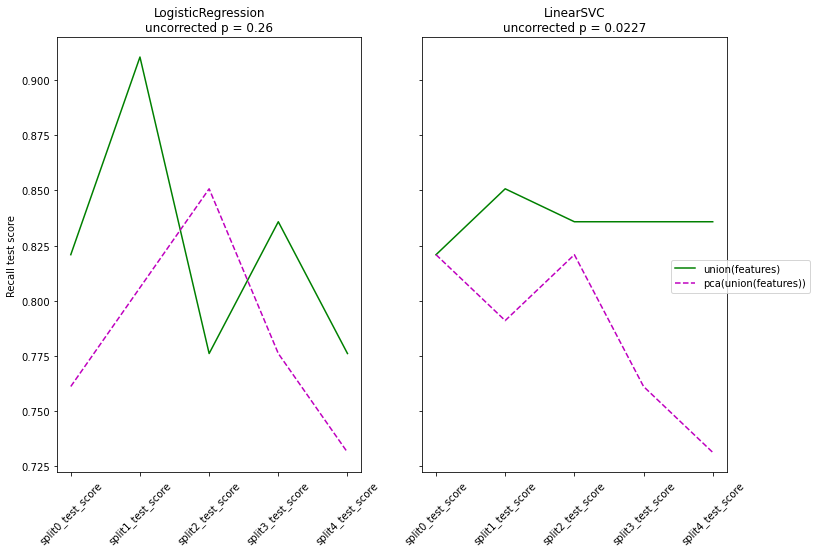

In [10]:
# let's compare the best scoring models once again
lr_union_pca_scores = results_dict['lr_pca']['scores'].iloc[0]
svc_union_pca_scores = results_dict['svc_pca']['scores'].iloc[0]

_, p_within_lr = ttest_ind(lr_union_scores, lr_union_pca_scores)
_, p_within_svc = ttest_ind(svc_union_scores, svc_union_pca_scores)

fig, (ax_lr, ax_svc) = plt.subplots(1, 2, figsize=(12,8), sharex=True, sharey=True)
ax_lr.plot(lr_union_scores.T, label='union(features)', c='g')
ax_lr.plot(lr_union_pca_scores.T, ls='--', label='pca(union(features))', c='m')
ax_svc.plot(svc_union_scores.T, c='g')
ax_svc.plot(svc_union_pca_scores.T, ls='--', c='m')
for ax in [ax_lr, ax_svc]:
    ax.set_xticklabels(cols, rotation=45)

ax_lr.set_title(f'LogisticRegression\nuncorrected p = {p_within_lr.round(4)}')
ax_svc.set_title(f'LinearSVC\nuncorrected p = {p_within_svc.round(4)}')
labels, handles = ax_lr.get_legend_handles_labels()
ax_lr.set_ylabel('Recall test score')
fig.legend(labels, handles, 'center right')

In [11]:
print(ttest_ind(lr_union_pca_scores, svc_union_pca_scores))

Ttest_indResult(statistic=0.0, pvalue=1.0)
